In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
import os
import random
import zipfile
from copy import deepcopy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim.lr_scheduler as lr_scheduler
from PIL import Image
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from torchvision import datasets, transforms
from torchvision.transforms.v2 import RandomZoomOut
from torchvision.transforms import Compose, RandomApply, RandomResizedCrop, ColorJitter, RandomRotation, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, CenterCrop, Lambda, Pad
from dinov2.models.vision_transformer import vit_small, vit_base, vit_large, vit_giant2
import shutil
import requests
import random
import time
import re
import traceback
import pandas as pd

In [4]:
# define directories of image data as follows for training / testing:
#
# images_directory                 
# - class_name_1                                   *class directories can have any name
# - - image_1_of_class_1.jpg                       *image files can have any name
# - - image_2_of_class_1.jpeg
# - class_name_2 
# - - image_1_of_class_2.png
# - - image_2_of_class_2.jpg
# - - ...
#

main_directory = "/home/photon/4tb"
images_directory = Path("{}/images".format(main_directory))

In [5]:
# start by reporting how many image examples there are per class
n_images_per_class = 16

# to handle "class imbalance", we equalize the number of examples used per class
n_val_images_per_class = 1
n_train_images_per_class = n_images_per_class - n_val_images_per_class

# train / validation image directories will be created, with symlinks to the original images directory
train_dir = '{}/train'.format(main_directory)            
validation_dir = '{}/validation'.format(main_directory)

In [6]:
# def analyze_image_counts(directory_path, min_images_per_class):
#     # gather class directories
#     class_folders = [f for f in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, f))]
#     image_counts = []
    
#     # gather image data from class directories
#     for folder in class_folders:
#         folder_path = os.path.join(directory_path, folder)
#         images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
#         image_counts.append(len(images))
    
#     # metrics of classes with enough images
#     total_classes = len(image_counts)
#     classes_above_threshold = sum(count >= min_images_per_class for count in image_counts)
#     percent_above_threshold = (classes_above_threshold / total_classes) * 100
#     print("{:.2f}% ({:,} of {:,}) classes have at least {} images".format(percent_above_threshold,
#                                                                           classes_above_threshold,
#                                                                           total_classes,
#                                                                           n_images_per_class))
#     # plot the distribution of examples per class
#     plt.figure(figsize=(10, 6))
#     n_bins = 50 if total_classes > 50 else total_classes
#     plt.hist(image_counts, bins=300, color='black', edgecolor='black')
#     plt.title("Distribution of Image Counts per Class")
#     plt.xlabel("Number of Images")
#     plt.ylabel("Frequency")
#     plt.grid(axis='y', alpha=0.75)
#     plt.show()
#     plt.savefig('class_dataset_distribution.png')

In [7]:
# analyze_image_counts(directory_path = images_directory, min_images_per_class = n_images_per_class)

In [8]:
# import random

# def select_train_and_validation_images(filenames):
#     gbif_to_inaturalist_count = {}

#     # First pass: Count occurrences of GBIF numbers
#     for filename in filenames:
#         if "lat" not in filename:
#             continue
#         parts = filename.split('_')
#         gbif_number = parts[1][4:]
#         gbif_to_inaturalist_count[gbif_number] = gbif_to_inaturalist_count.get(gbif_number, 0) + 1

#     # Select one GBIF number with a single iNaturalist occurrence for validation
#     validation_candidates = [gbif for gbif, count in gbif_to_inaturalist_count.items() if count == 1]
#     if not validation_candidates:
#         # if we can't find an isolated image, fine, let's just grab one that has another example in same observation
#         validation_candidates = [gbif for gbif in gbif_to_inaturalist_count.keys()]
#         if not validation_candidates:
#             return None, None
                                 
#     validation_gbif_number = random.choice(validation_candidates)

#     validation_images = []
#     train_images = []

#     # Second pass: Allocate files to validation and training sets
#     for filename in filenames:
#         if "lat" not in filename:
#             continue
#         parts = filename.split('_')
#         gbif_number = parts[1][4:]

#         if gbif_number == validation_gbif_number:
#             validation_images.append(filename)
#         else:
#             train_images.append(filename)

#     return validation_images, train_images


# # make new train and validation directories (delete any that exist already)    
# for dir_path in [train_dir, validation_dir]:
#     if os.path.exists(dir_path):
#         shutil.rmtree(dir_path)
#     os.makedirs(dir_path)

# # gather all potential class folders
# class_folders = [f for f in os.listdir(images_directory) if os.path.isdir(os.path.join(images_directory, f))]

# n_classes = len(class_folders)
# percent_report = 0.01
# report_interval = int(n_classes * percent_report)

# for class_num, folder in enumerate(class_folders):
#     if class_num % report_interval = 0:
#         print("Processed training/validation dataset for {:,} classes".format(class_num))
#     class_folder_path = os.path.join(images_directory, folder)
    
#     # get all potential images
#     images = [img for img in os.listdir(class_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

#     if len(images) >= (n_train_images_per_class + n_val_images_per_class):
        
#         # randomly select images for training and validation
#         # random.shuffle(images)
        
# #         validation_images = [select_random_validation_image_from_unique_gbif_observation()]
#         validation_images, training_images = select_train_and_validation_images(images)
    
#         if type(validation_images) == type(None):
#             continue
    
#         if len(training_images) < n_train_images_per_class or len(validation_images) < 1:
#             continue
        
# #         training_images = images[:n_train_images_per_class]
# #         validation_images = images[n_train_images_per_class:n_train_images_per_class + n_val_images_per_class]

#         # create the new class train sub-directory if needed
#         train_sub_dir = os.path.join(train_dir, folder)
#         if not os.path.exists(train_sub_dir):
#             os.makedirs(train_sub_dir)
        
#         # symlink from original image directory to this directory
#         for img in training_images:
#             src_path = os.path.join(class_folder_path, img)
#             dst_path = os.path.join(train_sub_dir, img)
#             os.symlink(src_path, dst_path)

#         # create the new class validation sub-directory if needed
#         validation_sub_dir = os.path.join(validation_dir, folder)
#         if not os.path.exists(validation_sub_dir):
#             os.makedirs(validation_sub_dir)
        
#         # symlink from original image directory to this directory
#         for img in validation_images:
#             src_path = os.path.join(class_folder_path, img)
#             dst_path = os.path.join(validation_sub_dir, img)
#             os.symlink(src_path, dst_path)

In [9]:
# analyze_image_counts(directory_path = train_dir, min_images_per_class = n_train_images_per_class)

 [--Original Image--]   [-------------------------------Sampled Data Augmentations-------------------------------] 


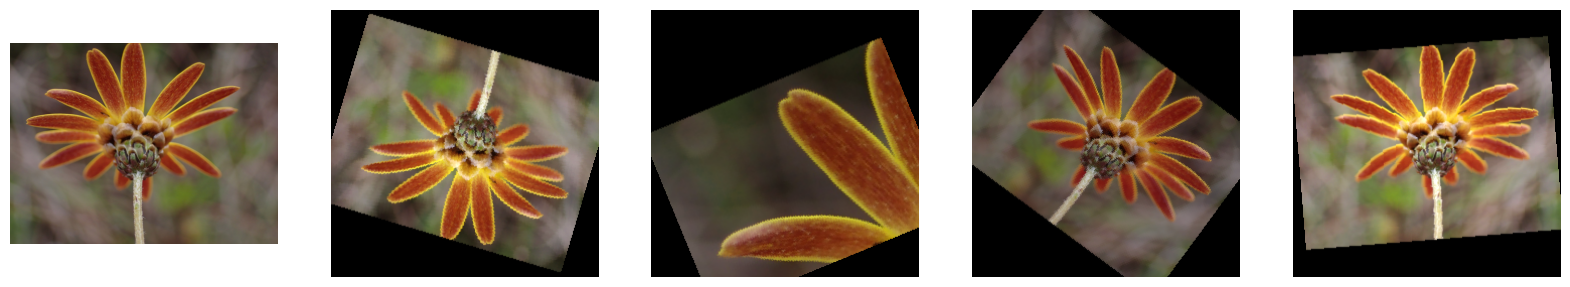

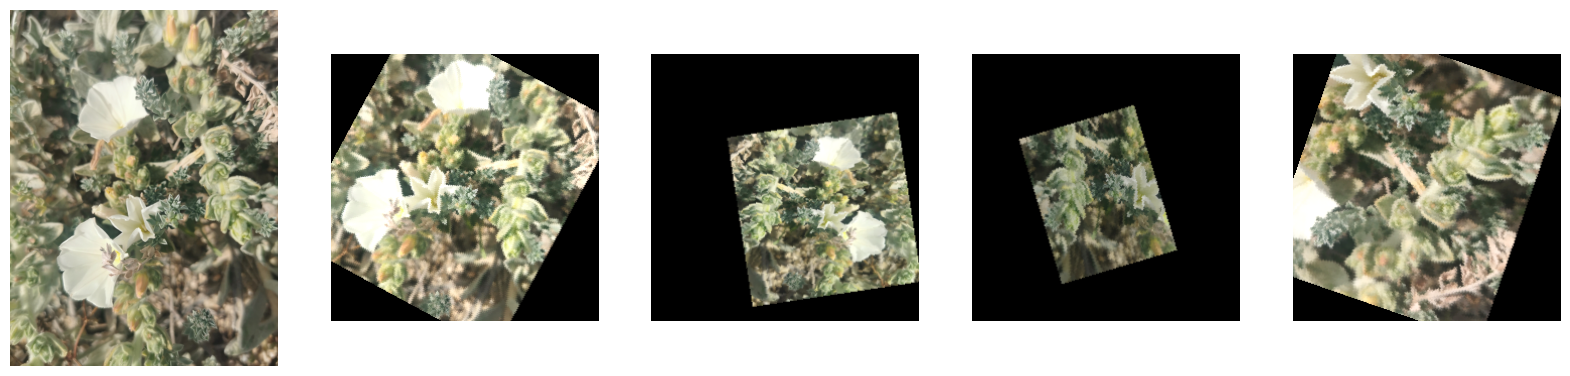

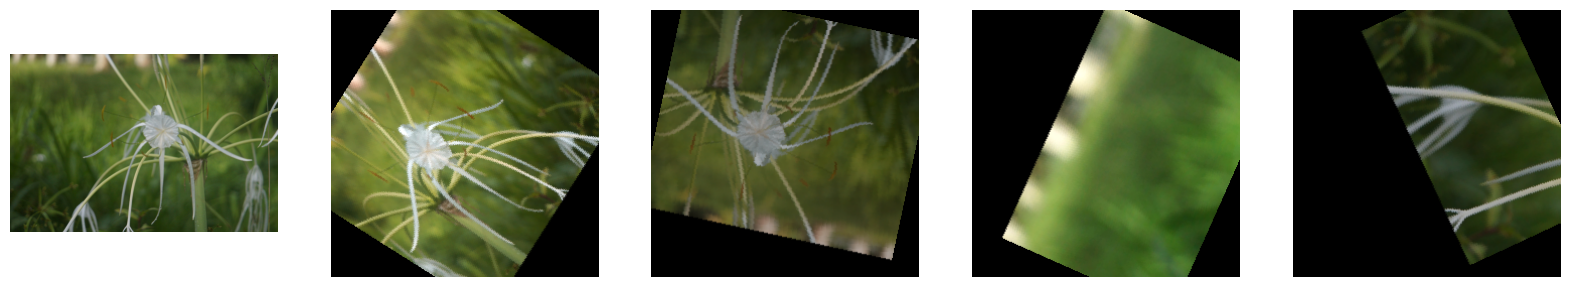

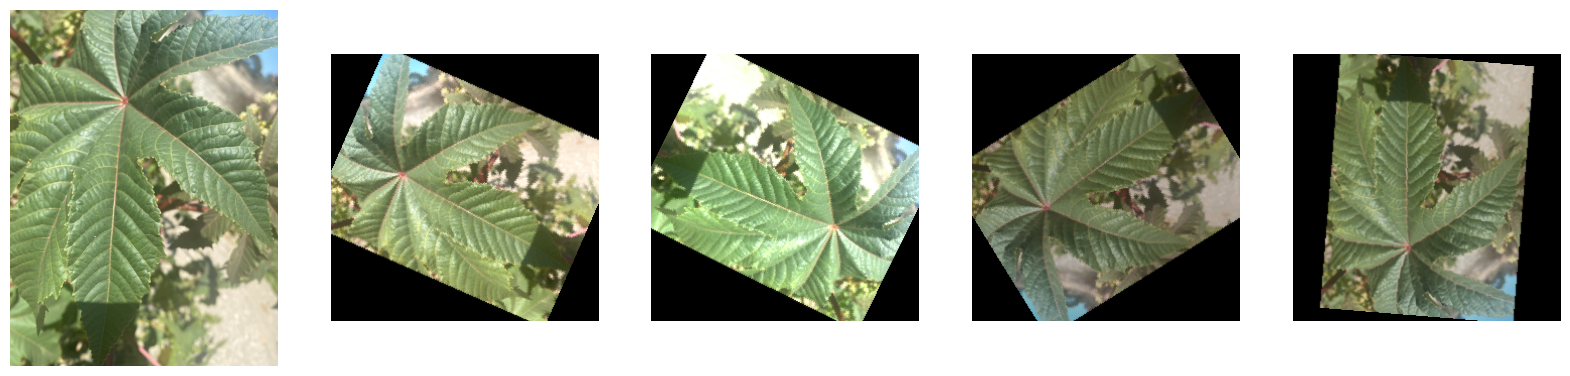

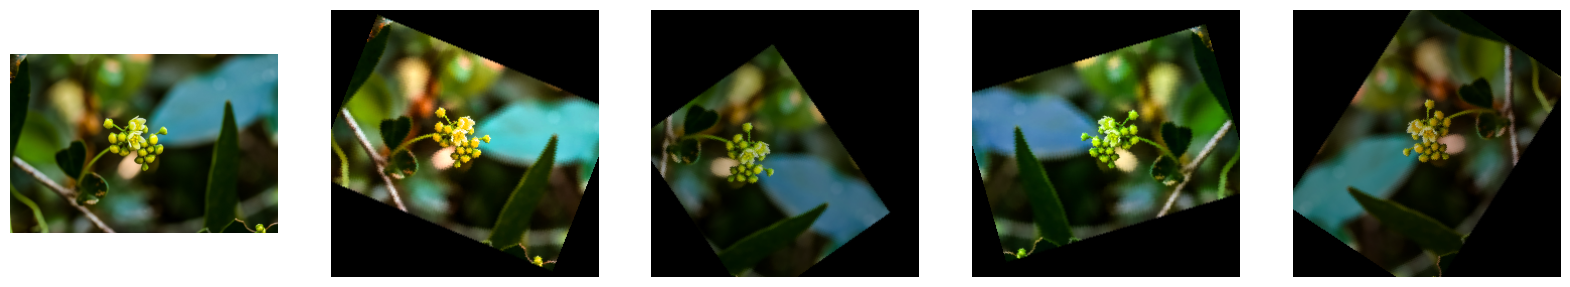

In [10]:
# prepare and visualize data pre-processing, including data augmentations
seed = 2**10
random.seed(seed)
torch.manual_seed(seed)

class ResizeAndPad:
    def __init__(self, target_size, multiple):
        self.target_size = target_size
        self.multiple = multiple

    def __call__(self, img):
        # Resize the image
        img = transforms.Resize(self.target_size)(img)

        # Calculate padding
        pad_width = (self.multiple - img.width % self.multiple) % self.multiple
        pad_height = (self.multiple - img.height % self.multiple) % self.multiple

        # Apply padding
        img = transforms.Pad((pad_width // 2, pad_height // 2, pad_width - pad_width // 2, pad_height - pad_height // 2))(img)
        
        return img
    
def center_crop_to_square(img):
    # Determine the dimensions of the image
    width, height = img.size

    # Find the smaller dimension
    min_dim = min(width, height)

    # Define the cropping box
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = (width + min_dim) // 2
    bottom = (height + min_dim) // 2

    # Crop the image
    img = img.crop((left, top, right, bottom))
    return img
    
def pad_to_square(img):
    # Determine the dimensions of the image
    width, height = img.size

    # Calculate padding
    if width > height:
        pad = (width - height) // 2
        padding = (0, pad, 0, pad)  # left, top, right, bottom
    else:
        pad = (height - width) // 2
        padding = (pad, 0, pad, 0)  # left, top, right, bottom

    # Pad the image
    return Pad(padding, fill=0)(img)
    
def load_random_image_from_directory(train_dir):
    # Get all class sub-folders
    class_folders = [f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))]
    if not class_folders:
        return None

    # Randomly select a class
    selected_class = random.choice(class_folders)
    class_folder_path = os.path.join(train_dir, selected_class)

    # Get all images in the selected class folder
    images = [img for img in os.listdir(class_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not images:
        return None
    
    for i in range(10):
        try:
            # Randomly select an image
            selected_image = random.choice(images)
            image_path = os.path.join(class_folder_path, selected_image)
            image_data = Image.open(image_path)
            break

        except:
#             print("Error loading image")
            continue

    return image_data
    

# size of image to train DinoV2 with
image_dimension = 256
target_size = (image_dimension, image_dimension)

# data augmentations for simulating dataset distributions (change as needed)
# https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_illustrations.html
image_preprocessing = {
    "train":     Compose( [Lambda(pad_to_square),
                           RandomApply([RandomResizedCrop(size=(image_dimension*2, image_dimension*2)),
                                        RandomZoomOut(side_range=(1.0, 2.0))], p=0.5),
                           ResizeAndPad(target_size, 14),
                           ColorJitter(brightness=.3, hue=.04),
                           RandomRotation(360),
                           RandomHorizontalFlip(),
                           RandomVerticalFlip(),
                           ToTensor()]),
    
    "test":     Compose( [ Lambda(pad_to_square),
                           ResizeAndPad((image_dimension*2, image_dimension*2), 14),
                           ToTensor()]),
    }


#  Compose([ CenterCrop((int(image_dimension), int(image_dimension))),
#                            ResizeAndPad((int(image_dimension), int(image_dimension)), 14),
#                            ToTensor()])

n_training_images_to_view = 5

print(" [--Original Image--]   [-------------------------------Sampled Data Augmentations-------------------------------] ")
for training_image in range(n_training_images_to_view):
    n_augmentations_to_view_per_images = 5
    
    original_image = load_random_image_from_directory(train_dir)

    # Apply the transformation and display 10 examples
    plt.figure(figsize=(20, 10))
    plt.subplot(1, n_augmentations_to_view_per_images, 1)
    plt.imshow(original_image)
    plt.axis('off')

    for i in range(1, n_augmentations_to_view_per_images):
        transformed_image = image_preprocessing["train"](original_image)
        plt.subplot(1, n_augmentations_to_view_per_images, i + 1)
        plt.imshow(transformed_image.permute(1, 2, 0))
        plt.axis('off')

    plt.show()

# we add a last data normalization, which was not included in the data visualizations (for humans)
image_preprocessing["train"].transforms.append(
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
)
image_preprocessing["test"].transforms.append(
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
)

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
def get_geo_xyz(latitudes, longitudes):
    latitudes = latitudes.to(device)
    longitudes = longitudes.to(device)
    lats_augmented, longs_augmented = augment_coordinates(lats=latitudes, longs=longitudes)
    geo_xyz = project_gps_onto_sphere(latitudes=lats_augmented, longitudes=longs_augmented)
    return geo_xyz

def augment_coordinates(lats, longs, std_dev_meters=2500):
    # Constants
    meters_per_degree_lat = 111320
    std_dev_deg_lat = std_dev_meters / meters_per_degree_lat

    # Calculate the average latitude for longitude adjustment
    avg_lat = lats.mean()
    std_dev_deg_long = std_dev_meters / (meters_per_degree_lat * torch.cos(torch.deg2rad(avg_lat)))

    # Gaussian noise
    noise_lat = torch.normal(mean=0.0, std=std_dev_deg_lat, size=lats.shape).to(lats.device)
    noise_long = torch.normal(mean=0.0, std=std_dev_deg_long, size=longs.shape).to(longs.device)

    # Apply noise
    lats_augmented = lats + noise_lat
    longs_augmented = longs + noise_long

    return lats_augmented, longs_augmented


def project_gps_onto_sphere(latitudes, longitudes):
    # Convert latitudes and longitudes to radians
    latitudes = latitudes * (torch.pi / 180)
    longitudes = longitudes * (torch.pi / 180)

    # Calculate spatial mapping
    x = torch.cos(latitudes) * torch.cos(longitudes)
    y = torch.cos(latitudes) * torch.sin(longitudes)
    z = torch.sin(latitudes)

    # Stack the results into a single tensor
    return torch.stack((x, y, z), dim=1)

In [13]:
# Create a custom dataset loader that will return image name (which contains lat/lon geo info) in addition to image data and label 

class CustomImageFolderDataset(datasets.ImageFolder):
    def __init__(self, root, transform=None, dataset_type="train"):
        super(CustomImageFolderDataset, self).__init__(root, transform)
        self.dataset_type = dataset_type
        
        # Pre-compute latitudes and longitudes for all images
        self.latitudes, self.longitudes = self.precompute_lat_lon()
        
    def precompute_lat_lon(self):
        filtered_imgs = []
        latitudes = []
        longitudes = []
        print("\nPre-extracting latitudes and longitudes from {:,} images in {} dataset, once...".format(len(self.imgs), self.dataset_type))
        
        for path, _ in self.imgs:
            filename = os.path.basename(path)
            match = re.search(r'lat([+-]?\d+\.\d+)_lon([+-]?\d+\.\d+)', filename)
            if match:
                filtered_imgs.append((path, _))
                latitudes.append(float(match.group(1)))
                longitudes.append(float(match.group(2)))
        
        # Update self.imgs to include only images with valid latitude and longitude
        self.imgs = filtered_imgs

        print("  -> Finished extracting {:,} images with {:,} latitudes and longitudes in their filename.".format(len(self.imgs), len(latitudes)))
        return torch.tensor(latitudes), torch.tensor(longitudes)

    def __getitem__(self, index):
        # This gets the original tuple of (image, label)
        original_tuple = super(CustomImageFolderDataset, self).__getitem__(index)

        latitude = self.latitudes[index]
        longitude = self.longitudes[index]
        
        # Return image, latitude, longitude, and label
        return original_tuple[0], latitude, longitude, original_tuple[1]    


# we will ensure that every class is evenly sampled, which is one way to tackle the class imbalance problem
# this way, instead of sampling only a limited number of examples for every class, we use all data available, but don't bias the neural network to one class
def make_weights_for_balanced_sampling(images, nclasses, device=device):
    # Extract class labels
    labels = torch.tensor([item[1] for item in images], device=device)

    # Count number of instances per class
    counts_per_class = torch.bincount(labels, minlength=nclasses).float()

    # Total number of images
    total_image_count = counts_per_class.sum()

    # Constant value for each class
    constant_per_class = 1.0 / nclasses

    # Calculate the sampling probability per image for each class
    sampling_probability_per_image = constant_per_class / counts_per_class

    # Apply this probability to all instances
    weights = sampling_probability_per_image[labels]

    # Convert to numpy for reporting
    sampling_probability_per_image_np = sampling_probability_per_image.cpu().numpy() * 100  # Convert to percentage

    return weights, sampling_probability_per_image_np, counts_per_class



print("Pre-processing custom image datasets (may take just a few minutes if dataset is very large)...")
train_data = {"train": CustomImageFolderDataset(train_dir, transform=image_preprocessing["train"], dataset_type="train")}
test_data = {"test": CustomImageFolderDataset(validation_dir, transform=image_preprocessing["test"], dataset_type="test")}

print("\nSampling probabilities per class (inversely proportional to number of images, to solve \"class imbalance\")...")
weights_train, sampling_probability_per_class, image_counts_per_class = make_weights_for_balanced_sampling(train_data["train"].imgs, len(train_data["train"].classes), device=device)
weights_test, _, _ = make_weights_for_balanced_sampling(test_data["test"].imgs, len(test_data["test"].classes), device=device)

n_examples_to_report = 15
for example_number, (probability, image_count, class_name) in enumerate(zip(sampling_probability_per_class, image_counts_per_class, train_data["train"].classes)):
    print("\"{}\" has {} images -> sampling likelihood per image {:.6f}% ...".format(class_name, int(image_count), probability))
    if example_number == n_examples_to_report:
        break
print("...")

Pre-processing custom image datasets (may take just a few minutes if dataset is very large)...

Pre-extracting latitudes and longitudes from 2,603,128 images in train dataset, once...
  -> Finished extracting 2,603,112 images with 2,603,112 latitudes and longitudes in their filename.

Pre-extracting latitudes and longitudes from 33,834 images in test dataset, once...
  -> Finished extracting 33,834 images with 33,834 latitudes and longitudes in their filename.

Sampling probabilities per class (inversely proportional to number of images, to solve "class imbalance")...
"10010617" has 106 images -> sampling likelihood per image 0.000028% ...
"10021011" has 99 images -> sampling likelihood per image 0.000030% ...
"10025353" has 105 images -> sampling likelihood per image 0.000028% ...
"10030768" has 99 images -> sampling likelihood per image 0.000030% ...
"10038477" has 23 images -> sampling likelihood per image 0.000129% ...
"10045705" has 29 images -> sampling likelihood per image 0.000

In [14]:
# create the training & test datasets with baked-in pre-processing and sampling
train_batch_size = 512
test_batch_size = 64

# Create samplers
sampler_train = torch.utils.data.WeightedRandomSampler(weights_train, len(weights_train))
sampler_test = torch.utils.data.WeightedRandomSampler(weights_test, len(weights_test))

dataloaders = {"train": torch.utils.data.DataLoader(train_data["train"], 
                                                    batch_size=train_batch_size, 
                                                    sampler=sampler_train,
                                                    num_workers=12,      # Depends on your system's CPU; more workers can load data faster
                                                    pin_memory=True),    # Useful if you are using a GPU
               
                "test": torch.utils.data.DataLoader(test_data["test"], 
                                                    batch_size=test_batch_size, 
                                                    sampler=sampler_test,
                                                    num_workers=12,
                                                    pin_memory=True),                                                                                    
                }

class_names = train_data["train"].classes

In [15]:
file_path = '/home/photon/sense/3cology/research/herbarium/100k_global_plant_species.csv'
df = pd.read_csv(file_path, sep=',')

# Extract each column into a separate list
species_list = df['species'].tolist()
species_key_list = df['speciesKey'].tolist()

species_id_to_name = dict(zip(df['speciesKey'], df['species']))

In [16]:
# It should say "Monstera deliciosa"
print(species_id_to_name[2868241])

Monstera deliciosa


In [17]:
def download_file(url, local_path):
    print("Downloading {}...".format(url))
    response = requests.get(url, stream=True)
    with open(local_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192): 
            if chunk: 
                f.write(chunk)

# https://github.com/dqshuai/MetaFormer/blob/master/models/meta_encoder.py
class ResNormLayer(nn.Module):
    def __init__(self, linear_size,):
        super(ResNormLayer, self).__init__()
        self.l_size = linear_size
        self.nonlin1 = nn.ReLU()
        self.nonlin2 = nn.ReLU()
        self.norm_fn1 = nn.LayerNorm(self.l_size)
        self.norm_fn2 = nn.LayerNorm(self.l_size)
        self.w1 = nn.Linear(self.l_size, self.l_size)
        self.w2 = nn.Linear(self.l_size, self.l_size)

    def forward(self, x):
        y = self.w1(x)
        y = self.nonlin1(y)
        y = self.norm_fn1(y)
        y = self.w2(y)
        y = self.nonlin2(y)
        y = self.norm_fn2(y)
        out = x + y
        return out
    
                
# Define a new classifier layer that contains a few linear layers with a ReLU to make predictions positive
class DinoVisionTransformerClassifier(nn.Module):
    
    def __init__(self, model_size="small", n_classes=1):
        super(DinoVisionTransformerClassifier, self).__init__()
        self.model_size = model_size
        
        # loading a model with registers
        n_register_tokens = 4
        
        if model_size == "small":        
            self.transformer = vit_small(patch_size=14,
                                  img_size=526,
                                  init_values=1.0,
                                  num_register_tokens=n_register_tokens,
                                  block_chunks=0)
            self.embedding_size = 384
            self.number_of_heads = 6
            
        elif model_size == "base":
            self.transformer = vit_base(patch_size=14,
                                 img_size=526,
                                 init_values=1.0,
                                 num_register_tokens=n_register_tokens,
                                 block_chunks=0)
            self.embedding_size = 768
            self.number_of_heads = 12

        elif model_size == "large":
            self.transformer = vit_large(patch_size=14,
                                  img_size=526,
                                  init_values=1.0,
                                  num_register_tokens=n_register_tokens,
                                  block_chunks=0)
            self.embedding_size = 1024
            self.number_of_heads = 16
            
        elif model_size == "giant":
            self.transformer = vit_giant2(patch_size=14,
                                   img_size=526,
                                   init_values=1.0,
                                   num_register_tokens=n_register_tokens,
                                   block_chunks=0)
            self.embedding_size = 1536
            self.number_of_heads = 24
            
        self.load_model_weights()
                      
        # geo encoder below inspired by https://arxiv.org/pdf/2203.02751.pdf
        geo_1_size = 348
        
        self.geo_encoder_1 = nn.Sequential(nn.Linear(3, geo_1_size),
                                           nn.ReLU(),
                                           nn.LayerNorm(geo_1_size),
                                           ResNormLayer(geo_1_size)).to(device)
                
        self.classifier = nn.Sequential(nn.Linear(self.embedding_size + geo_1_size, self.embedding_size + geo_1_size), 
                                        nn.Sigmoid(), 
                                        nn.Linear(self.embedding_size + geo_1_size, n_classes))

        
    def load_model_weights(self):
        weights_map = {
            "small": "dinov2_vits14_reg4_pretrain.pth",
            "base":  "dinov2_vitb14_reg4_pretrain.pth",
            "large": "dinov2_vitl14_reg4_pretrain.pth",
            "giant": "dinov2_vitg14_reg4_pretrain.pth"
        }
        urls_map = {
            "small": "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth",
            "base":  "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_reg4_pretrain.pth",
            "large": "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitl14/dinov2_vitl14_reg4_pretrain.pth",
            "giant": "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitg14/dinov2_vitg14_reg4_pretrain.pth"
        }

        weight_file = weights_map[self.model_size]
        local_path = Path(main_directory) / weight_file

        # Check if the file exists
        if not local_path.exists():
            print(f"Downloading weights for {self.model_size} model...")
            download_file(urls_map[self.model_size], local_path)

        # Load the weights
        self.transformer.load_state_dict(torch.load(local_path))

        
    def forward(self, x, geo_xyz=None):
        
        # process image data with DinoV2 frozen features
        with torch.no_grad():
            x = self.transformer(x)
            image_embedding = self.transformer.norm(x)
        
        if geo_xyz is None:
            latitude  = torch.tensor(40.730610, dtype=torch.float32).to(device)
            longitude = torch.tensor(-73.935242, dtype=torch.float32).to(device)
            geo_xyz = get_geo_xyz(latitude.unsqueeze(0), longitude.unsqueeze(0)).to(device)

        # embed XYZ coordinates
        geo_embedding_1 = self.geo_encoder_1(geo_xyz)

        classifier_input = torch.cat((image_embedding, geo_embedding_1), dim=1)
        classifier_output = self.classifier(classifier_input)
              
        return classifier_output

In [18]:
model = DinoVisionTransformerClassifier("large", n_classes=len(class_names))

model.load_state_dict(torch.load('{}/large_geo_classifier_33k_401k_epochs.pth'.format(main_directory)), strict=False)

model.eval()

DinoVisionTransformerClassifier(
  (transformer): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-23): 24 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (drop): Dropout(p

In [19]:
model = model.to(device)

In [20]:
# Rely on DinoV2 features, which frees up a lot of memory for training bigger heads, bigger batches
for param in model.transformer.parameters():
    param.requires_grad = False

# https://pytorch.org/docs/stable/nn.html#loss-functions
criterion = nn.CrossEntropyLoss() 

model = model.train()

def calculate_accuracy(outputs, labels):
    # Convert outputs to predicted classes
    _, predicted_classes = torch.max(outputs, 1)
    # Calculate accuracy
    correct_predictions = (predicted_classes == labels).sum().item()
    total_predictions = labels.size(0)
    return correct_predictions / total_predictions

In [21]:
epoch_losses = []
epoch_accuracies = []

print("Training...")

epoch = 401000
max_epochs = 2000000

train_losses = []
train_accuracies = []

test_losses = []
test_accuracies = []

validation_testing_frequency = 100
report_train_epoch_frequency = 10
save_model_frequency = 5000

train_model = True
cumulative_test = False
mask_geo_knowledge = True


# Warm-up and decay settings
total_epochs = 2000000
gamma = 0.99996
warmup_epochs = 100
initial_lr = 0.0009
min_lr = 1e-6

# train the geo-encoders and train the classifier, only
trainable_params = list(model.geo_encoder_1.parameters()) + \
                   list(model.classifier.parameters())

optimizer = optim.AdamW(trainable_params, lr=initial_lr, betas=(0.9, 0.999))

# Lambda function for warm-up, decay, and minimum learning rate
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        # Linear warm-up
        return (epoch / warmup_epochs)
    else:
        # Exponential decay
        lr = gamma ** (epoch - warmup_epochs)
        # Clamp to minimum learning rate
        return max(lr, min_lr / initial_lr)
    
# Scheduler
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda)




def train_epoch(train_data_for_epoch, mask_geo=False):
    
    # get the input batch and the labels
    batch_of_images, latitudes, longitudes, labels = train_data_for_epoch #  geo_xyz
    
    if mask_geo:
        # welcome to Null Island https://blogs.loc.gov/maps/2016/04/the-geographical-oddity-of-null-island/#:~:text=Null%20Island%20is%20an%20imaginary,Equator%20meets%20the%20Prime%20Meridian.
        new_latitudes  = torch.tensor([0.00000 for _ in range(latitudes.shape[0])], dtype=torch.float32).to(device)
        new_longitudes = torch.tensor([0.00000 for _ in range(longitudes.shape[0])], dtype=torch.float32).to(device)
        geo_xyz = get_geo_xyz(new_latitudes, new_longitudes).to(device)
    else:
        geo_xyz = get_geo_xyz(latitudes, longitudes)

    # zero the parameter gradients
    optimizer.zero_grad()

    # model prediction
    output = model(batch_of_images.to(device), geo_xyz).squeeze(dim=1) #  geo_xyz.to(device)

    # compute loss and do backpropagation
    loss = criterion(output, labels.to(device))
        
    loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        train_losses.append(loss.item())

        # Calculate and record batch accuracy
        accuracy = calculate_accuracy(output, labels.to(device))
        train_accuracies.append(accuracy)
        
        if epoch % report_train_epoch_frequency == 0:
            mean_train_loss = torch.mean(torch.tensor(train_losses[-30:]))
            mean_train_accuracy = torch.mean(torch.tensor(train_accuracies[-30:]))
            current_lr = scheduler.get_last_lr()[0]
            print("  -> ({:,}): TRAIN: [Loss = {:.5f}, Accuracy = {:.5f}%], LR: {:.8f}".format(epoch, mean_train_loss, 100*mean_train_accuracy, current_lr), flush=True)

    
def test_epoch(mask_geo):
    # zero the parameter gradients
    optimizer.zero_grad()
    
    with torch.no_grad():
        if len(train_losses) > 0:
            mean_train_loss = torch.mean(torch.tensor(train_losses[-30:]))
            mean_train_accuracy = torch.mean(torch.tensor(train_accuracies[-30:]))

        test_data_iter = iter(dataloaders["test"])
        test_batch_of_images, test_latitudes, test_longitudes, test_labels = next(test_data_iter) # test_geo_xyz

        
        if mask_geo:
            # welcome to Null Island https://blogs.loc.gov/maps/2016/04/the-geographical-oddity-of-null-island/#:~:text=Null%20Island%20is%20an%20imaginary,Equator%20meets%20the%20Prime%20Meridian.
            new_latitudes  = torch.tensor([0.00000 for _ in range(test_latitudes.shape[0])], dtype=torch.float32).to(device)
            new_longitudes = torch.tensor([0.00000 for _ in range(test_longitudes.shape[0])], dtype=torch.float32).to(device)
            test_geo_xyz = get_geo_xyz(new_latitudes, new_longitudes).to(device)
        else:
            test_geo_xyz = get_geo_xyz(test_latitudes, test_longitudes)

        
        
        # model prediction
        test_output = model(test_batch_of_images.to(device), test_geo_xyz).squeeze(dim=1) # , test_geo_xyz.to(device)
        test_loss = criterion(test_output, test_labels.to(device))

        test_losses.append(test_loss.item())
        test_accuracy = calculate_accuracy(test_output, test_labels.to(device))
        test_accuracies.append(test_accuracy)
        
        if cumulative_test:
            lookback_tests = 0
        else:
            lookback_tests = -1
        
        mean_test_loss = torch.mean(torch.tensor(test_losses[lookback_tests:]))
        mean_test_accuracy = torch.mean(torch.tensor(test_accuracies[lookback_tests:]))

        current_lr = scheduler.get_last_lr()[0]
        
        if len(train_losses) > 0:
            print("  -> ({:,}): TRAIN: [Loss = {:.5f}, Accuracy = {:.5f}%], TEST: [Loss = {:.5f}, Accuracy = {:.5f}%], LR: {:.8f}".format(epoch, mean_train_loss, 100*mean_train_accuracy, mean_test_loss, 100*mean_test_accuracy, current_lr), flush=True)

        else:
            print("  -> ({:,}): TEST: [Loss = {:.5f}, Accuracy = {:.5f}%], LR: {:.8f}".format(epoch, mean_test_loss, 100*mean_test_accuracy, current_lr), flush=True)

            

while epoch < max_epochs:
    try:
        
        for train_data_for_epoch in dataloaders["train"]:
        
            if epoch >= max_epochs:
                break

            if epoch % validation_testing_frequency == 0:
                test_epoch(mask_geo=mask_geo_knowledge)

            if train_model:
                train_epoch(train_data_for_epoch, mask_geo=mask_geo_knowledge)

            epoch += 1

            if epoch % save_model_frequency == 0 and epoch != 0:
                torch.save(model.state_dict(), '{}/large_geo_33k_species_classifier_renaissance_frozen_epoch_{}.pth'.format(main_directory,epoch))
            
    except Exception as e:
        print("Error: {}".format(e))
        traceback.print_exc()
        continue
        

Training...
  -> (401,000): TEST: [Loss = 1.88232, Accuracy = 60.93750%], LR: 0.00000000
  -> (401,000): TRAIN: [Loss = 1.23085, Accuracy = 70.50781%], LR: 0.00000900
  -> (401,010): TRAIN: [Loss = 1.22305, Accuracy = 71.09375%], LR: 0.00009900
  -> (401,020): TRAIN: [Loss = 1.21272, Accuracy = 71.90290%], LR: 0.00018900
  -> (401,030): TRAIN: [Loss = 1.22210, Accuracy = 71.79688%], LR: 0.00027900
  -> (401,040): TRAIN: [Loss = 1.22500, Accuracy = 71.74480%], LR: 0.00036900
  -> (401,050): TRAIN: [Loss = 1.20849, Accuracy = 71.90755%], LR: 0.00045900
  -> (401,060): TRAIN: [Loss = 1.18221, Accuracy = 72.66276%], LR: 0.00054900
  -> (401,070): TRAIN: [Loss = 1.17902, Accuracy = 73.17057%], LR: 0.00063900
  -> (401,080): TRAIN: [Loss = 1.18241, Accuracy = 73.20964%], LR: 0.00072900
  -> (401,090): TRAIN: [Loss = 1.18815, Accuracy = 72.53906%], LR: 0.00081900
  -> (401,100): TRAIN: [Loss = 1.19033, Accuracy = 72.20052%], TEST: [Loss = 1.24514, Accuracy = 70.31250%], LR: 0.00090000
  -> (4

  -> (401,900): TRAIN: [Loss = 1.22578, Accuracy = 71.88151%], LR: 0.00087162
  -> (401,910): TRAIN: [Loss = 1.20949, Accuracy = 71.88151%], LR: 0.00087127
  -> (401,920): TRAIN: [Loss = 1.18113, Accuracy = 72.25260%], LR: 0.00087092
  -> (401,930): TRAIN: [Loss = 1.17719, Accuracy = 72.69531%], LR: 0.00087058
  -> (401,940): TRAIN: [Loss = 1.20235, Accuracy = 72.82552%], LR: 0.00087023
  -> (401,950): TRAIN: [Loss = 1.18970, Accuracy = 73.26823%], LR: 0.00086988
  -> (401,960): TRAIN: [Loss = 1.20835, Accuracy = 72.76693%], LR: 0.00086953
  -> (401,970): TRAIN: [Loss = 1.19200, Accuracy = 72.68229%], LR: 0.00086918
  -> (401,980): TRAIN: [Loss = 1.21592, Accuracy = 72.20703%], LR: 0.00086884
  -> (401,990): TRAIN: [Loss = 1.19218, Accuracy = 72.70182%], LR: 0.00086849
  -> (402,000): TRAIN: [Loss = 1.18573, Accuracy = 72.59766%], TEST: [Loss = 1.51126, Accuracy = 64.06250%], LR: 0.00086818
  -> (402,000): TRAIN: [Loss = 1.18673, Accuracy = 72.65625%], LR: 0.00086814
  -> (402,010): TR

  -> (402,810): TRAIN: [Loss = 1.12438, Accuracy = 74.14062%], LR: 0.00084046
  -> (402,820): TRAIN: [Loss = 1.14997, Accuracy = 73.66536%], LR: 0.00084013
  -> (402,830): TRAIN: [Loss = 1.13453, Accuracy = 73.85416%], LR: 0.00083979
  -> (402,840): TRAIN: [Loss = 1.15085, Accuracy = 73.72396%], LR: 0.00083946
  -> (402,850): TRAIN: [Loss = 1.14656, Accuracy = 73.54818%], LR: 0.00083912
  -> (402,860): TRAIN: [Loss = 1.16072, Accuracy = 73.43750%], LR: 0.00083878
  -> (402,870): TRAIN: [Loss = 1.15771, Accuracy = 73.35938%], LR: 0.00083845
  -> (402,880): TRAIN: [Loss = 1.15460, Accuracy = 73.84766%], LR: 0.00083811
  -> (402,890): TRAIN: [Loss = 1.13141, Accuracy = 74.27734%], LR: 0.00083778
  -> (402,900): TRAIN: [Loss = 1.13601, Accuracy = 74.37500%], TEST: [Loss = 1.59719, Accuracy = 65.62500%], LR: 0.00083748
  -> (402,900): TRAIN: [Loss = 1.13816, Accuracy = 74.40104%], LR: 0.00083744
  -> (402,910): TRAIN: [Loss = 1.14195, Accuracy = 73.99740%], LR: 0.00083711
  -> (402,920): TR

  -> (403,720): TRAIN: [Loss = 1.10511, Accuracy = 74.72005%], LR: 0.00081042
  -> (403,730): TRAIN: [Loss = 1.12197, Accuracy = 74.36849%], LR: 0.00081010
  -> (403,740): TRAIN: [Loss = 1.12858, Accuracy = 74.24479%], LR: 0.00080977
  -> (403,750): TRAIN: [Loss = 1.12754, Accuracy = 74.06250%], LR: 0.00080945
  -> (403,760): TRAIN: [Loss = 1.13358, Accuracy = 74.17969%], LR: 0.00080912
  -> (403,770): TRAIN: [Loss = 1.14394, Accuracy = 74.12760%], LR: 0.00080880
  -> (403,780): TRAIN: [Loss = 1.12597, Accuracy = 74.76562%], LR: 0.00080848
  -> (403,790): TRAIN: [Loss = 1.11235, Accuracy = 74.73307%], LR: 0.00080815
  -> (403,800): TRAIN: [Loss = 1.11531, Accuracy = 74.71354%], TEST: [Loss = 1.57818, Accuracy = 64.06250%], LR: 0.00080786
  -> (403,800): TRAIN: [Loss = 1.11521, Accuracy = 74.71354%], LR: 0.00080783
  -> (403,810): TRAIN: [Loss = 1.12335, Accuracy = 74.58984%], LR: 0.00080751
  -> (403,820): TRAIN: [Loss = 1.09996, Accuracy = 75.02604%], LR: 0.00080718
  -> (403,830): TR

  -> (404,630): TRAIN: [Loss = 1.05062, Accuracy = 76.16537%], LR: 0.00078145
  -> (404,640): TRAIN: [Loss = 1.05268, Accuracy = 75.94402%], LR: 0.00078114
  -> (404,650): TRAIN: [Loss = 1.04469, Accuracy = 76.08724%], LR: 0.00078083
  -> (404,660): TRAIN: [Loss = 1.06763, Accuracy = 75.76823%], LR: 0.00078051
  -> (404,670): TRAIN: [Loss = 1.07364, Accuracy = 75.47526%], LR: 0.00078020
  -> (404,680): TRAIN: [Loss = 1.09526, Accuracy = 74.99349%], LR: 0.00077989
  -> (404,690): TRAIN: [Loss = 1.09515, Accuracy = 75.06511%], LR: 0.00077958
  -> (404,700): TRAIN: [Loss = 1.07866, Accuracy = 75.29948%], TEST: [Loss = 1.95043, Accuracy = 59.37500%], LR: 0.00077930
  -> (404,700): TRAIN: [Loss = 1.07687, Accuracy = 75.33203%], LR: 0.00077927
  -> (404,710): TRAIN: [Loss = 1.07766, Accuracy = 75.54037%], LR: 0.00077895
  -> (404,720): TRAIN: [Loss = 1.08422, Accuracy = 75.07162%], LR: 0.00077864
  -> (404,730): TRAIN: [Loss = 1.09452, Accuracy = 74.88281%], LR: 0.00077833
  -> (404,740): TR

  -> (405,540): TRAIN: [Loss = 1.06661, Accuracy = 75.97656%], LR: 0.00075352
  -> (405,550): TRAIN: [Loss = 1.05893, Accuracy = 76.21745%], LR: 0.00075322
  -> (405,560): TRAIN: [Loss = 1.05133, Accuracy = 76.40625%], LR: 0.00075291
  -> (405,570): TRAIN: [Loss = 1.03391, Accuracy = 76.57552%], LR: 0.00075261
  -> (405,580): TRAIN: [Loss = 1.03572, Accuracy = 76.54297%], LR: 0.00075231
  -> (405,590): TRAIN: [Loss = 1.00751, Accuracy = 76.97266%], LR: 0.00075201
  -> (405,600): TRAIN: [Loss = 1.00594, Accuracy = 77.05078%], TEST: [Loss = 1.79501, Accuracy = 70.31250%], LR: 0.00075174
  -> (405,600): TRAIN: [Loss = 1.00985, Accuracy = 77.01823%], LR: 0.00075171
  -> (405,610): TRAIN: [Loss = 1.00514, Accuracy = 76.88802%], LR: 0.00075141
  -> (405,620): TRAIN: [Loss = 1.01207, Accuracy = 76.73177%], LR: 0.00075111
  -> (405,630): TRAIN: [Loss = 0.99816, Accuracy = 76.84896%], LR: 0.00075081
  -> (405,640): TRAIN: [Loss = 1.03746, Accuracy = 76.25651%], LR: 0.00075051
  -> (405,650): TR

  -> (406,450): TRAIN: [Loss = 1.00707, Accuracy = 77.25912%], LR: 0.00072658
  -> (406,460): TRAIN: [Loss = 1.01599, Accuracy = 77.03776%], LR: 0.00072629
  -> (406,470): TRAIN: [Loss = 1.01863, Accuracy = 76.78385%], LR: 0.00072600
  -> (406,480): TRAIN: [Loss = 1.00165, Accuracy = 76.75781%], LR: 0.00072571
  -> (406,490): TRAIN: [Loss = 1.01424, Accuracy = 76.74479%], LR: 0.00072542
  -> (406,500): TRAIN: [Loss = 1.00733, Accuracy = 76.94010%], TEST: [Loss = 2.04567, Accuracy = 57.81250%], LR: 0.00072516
  -> (406,500): TRAIN: [Loss = 1.00809, Accuracy = 77.01823%], LR: 0.00072513
  -> (406,510): TRAIN: [Loss = 1.00583, Accuracy = 77.29818%], LR: 0.00072484
  -> (406,520): TRAIN: [Loss = 0.98713, Accuracy = 77.50000%], LR: 0.00072455
  -> (406,530): TRAIN: [Loss = 0.98730, Accuracy = 77.47395%], LR: 0.00072426
  -> (406,540): TRAIN: [Loss = 0.98814, Accuracy = 77.37630%], LR: 0.00072397
  -> (406,550): TRAIN: [Loss = 0.98817, Accuracy = 77.41537%], LR: 0.00072368
  -> (406,560): TR

  -> (407,360): TRAIN: [Loss = 0.98270, Accuracy = 77.83203%], LR: 0.00070061
  -> (407,370): TRAIN: [Loss = 0.99122, Accuracy = 77.48047%], LR: 0.00070033
  -> (407,380): TRAIN: [Loss = 0.96898, Accuracy = 77.79297%], LR: 0.00070005
  -> (407,390): TRAIN: [Loss = 0.95054, Accuracy = 77.92969%], LR: 0.00069977
  -> (407,400): TRAIN: [Loss = 0.92951, Accuracy = 78.25520%], TEST: [Loss = 1.95821, Accuracy = 70.31250%], LR: 0.00069952
  -> (407,400): TRAIN: [Loss = 0.92836, Accuracy = 78.24219%], LR: 0.00069949
  -> (407,410): TRAIN: [Loss = 0.95281, Accuracy = 77.83203%], LR: 0.00069921
  -> (407,420): TRAIN: [Loss = 0.97396, Accuracy = 77.56510%], LR: 0.00069893
  -> (407,430): TRAIN: [Loss = 0.98796, Accuracy = 77.70183%], LR: 0.00069865
  -> (407,440): TRAIN: [Loss = 0.98214, Accuracy = 77.68880%], LR: 0.00069837
  -> (407,450): TRAIN: [Loss = 0.95714, Accuracy = 78.13151%], LR: 0.00069809
  -> (407,460): TRAIN: [Loss = 0.97247, Accuracy = 77.38281%], LR: 0.00069781
  -> (407,470): TR

  -> (408,270): TRAIN: [Loss = 0.96343, Accuracy = 77.83854%], LR: 0.00067556
  -> (408,280): TRAIN: [Loss = 0.96520, Accuracy = 78.03385%], LR: 0.00067529
  -> (408,290): TRAIN: [Loss = 0.94664, Accuracy = 78.45703%], LR: 0.00067502
  -> (408,300): TRAIN: [Loss = 0.95559, Accuracy = 78.30078%], TEST: [Loss = 1.27976, Accuracy = 67.18750%], LR: 0.00067478
  -> (408,300): TRAIN: [Loss = 0.95533, Accuracy = 78.30078%], LR: 0.00067475
  -> (408,310): TRAIN: [Loss = 0.94716, Accuracy = 78.54817%], LR: 0.00067448
  -> (408,320): TRAIN: [Loss = 0.95625, Accuracy = 78.22266%], LR: 0.00067421
  -> (408,330): TRAIN: [Loss = 0.95524, Accuracy = 78.33334%], LR: 0.00067395
  -> (408,340): TRAIN: [Loss = 0.95059, Accuracy = 78.17709%], LR: 0.00067368
  -> (408,350): TRAIN: [Loss = 0.94796, Accuracy = 78.41146%], LR: 0.00067341
  -> (408,360): TRAIN: [Loss = 0.93618, Accuracy = 78.47656%], LR: 0.00067314
  -> (408,370): TRAIN: [Loss = 0.94770, Accuracy = 78.58724%], LR: 0.00067287
  -> (408,380): TR

  -> (409,180): TRAIN: [Loss = 0.92594, Accuracy = 78.91927%], LR: 0.00065142
  -> (409,190): TRAIN: [Loss = 0.92627, Accuracy = 78.97787%], LR: 0.00065116
  -> (409,200): TRAIN: [Loss = 0.93941, Accuracy = 78.89974%], TEST: [Loss = 1.14274, Accuracy = 71.87500%], LR: 0.00065092
  -> (409,200): TRAIN: [Loss = 0.93202, Accuracy = 78.99740%], LR: 0.00065089
  -> (409,210): TRAIN: [Loss = 0.94570, Accuracy = 78.79557%], LR: 0.00065063
  -> (409,220): TRAIN: [Loss = 0.93281, Accuracy = 78.95182%], LR: 0.00065037
  -> (409,230): TRAIN: [Loss = 0.91743, Accuracy = 79.05599%], LR: 0.00065011
  -> (409,240): TRAIN: [Loss = 0.90881, Accuracy = 79.15365%], LR: 0.00064985
  -> (409,250): TRAIN: [Loss = 0.91054, Accuracy = 79.22526%], LR: 0.00064959
  -> (409,260): TRAIN: [Loss = 0.91547, Accuracy = 79.16667%], LR: 0.00064933
  -> (409,270): TRAIN: [Loss = 0.91340, Accuracy = 79.21875%], LR: 0.00064907
  -> (409,280): TRAIN: [Loss = 0.91845, Accuracy = 78.88021%], LR: 0.00064882
  -> (409,290): TR

  -> (410,090): TRAIN: [Loss = 0.87977, Accuracy = 80.14974%], LR: 0.00062813
  -> (410,100): TRAIN: [Loss = 0.87298, Accuracy = 80.31250%], TEST: [Loss = 1.15465, Accuracy = 70.31250%], LR: 0.00062790
  -> (410,100): TRAIN: [Loss = 0.86830, Accuracy = 80.46224%], LR: 0.00062788
  -> (410,110): TRAIN: [Loss = 0.85570, Accuracy = 80.53386%], LR: 0.00062763
  -> (410,120): TRAIN: [Loss = 0.87117, Accuracy = 80.22135%], LR: 0.00062738
  -> (410,130): TRAIN: [Loss = 0.89217, Accuracy = 79.62891%], LR: 0.00062713
  -> (410,140): TRAIN: [Loss = 0.90525, Accuracy = 79.38151%], LR: 0.00062688
  -> (410,150): TRAIN: [Loss = 0.90627, Accuracy = 79.42057%], LR: 0.00062662
  -> (410,160): TRAIN: [Loss = 0.90025, Accuracy = 79.64193%], LR: 0.00062637
  -> (410,170): TRAIN: [Loss = 0.90059, Accuracy = 79.55730%], LR: 0.00062612
  -> (410,180): TRAIN: [Loss = 0.90650, Accuracy = 79.62239%], LR: 0.00062587
  -> (410,190): TRAIN: [Loss = 0.89534, Accuracy = 79.53125%], LR: 0.00062562
  -> (410,200): TR

  -> (411,000): TRAIN: [Loss = 0.85979, Accuracy = 80.22787%], TEST: [Loss = 1.82441, Accuracy = 62.50000%], LR: 0.00060570
  -> (411,000): TRAIN: [Loss = 0.85718, Accuracy = 80.28646%], LR: 0.00060568
  -> (411,010): TRAIN: [Loss = 0.87796, Accuracy = 80.03906%], LR: 0.00060543
  -> (411,020): TRAIN: [Loss = 0.88402, Accuracy = 79.55730%], LR: 0.00060519
  -> (411,030): TRAIN: [Loss = 0.88227, Accuracy = 79.39453%], LR: 0.00060495
  -> (411,040): TRAIN: [Loss = 0.88167, Accuracy = 79.70052%], LR: 0.00060471
  -> (411,050): TRAIN: [Loss = 0.88373, Accuracy = 79.92188%], LR: 0.00060447
  -> (411,060): TRAIN: [Loss = 0.87721, Accuracy = 80.11719%], LR: 0.00060423
  -> (411,070): TRAIN: [Loss = 0.87474, Accuracy = 79.94792%], LR: 0.00060398
  -> (411,080): TRAIN: [Loss = 0.85440, Accuracy = 80.19531%], LR: 0.00060374
  -> (411,090): TRAIN: [Loss = 0.88283, Accuracy = 79.77865%], LR: 0.00060350
  -> (411,100): TRAIN: [Loss = 0.87551, Accuracy = 80.13021%], TEST: [Loss = 1.41622, Accuracy =

  -> (411,900): TRAIN: [Loss = 0.87568, Accuracy = 79.64844%], LR: 0.00058426
  -> (411,910): TRAIN: [Loss = 0.86264, Accuracy = 79.87630%], LR: 0.00058403
  -> (411,920): TRAIN: [Loss = 0.87470, Accuracy = 79.98047%], LR: 0.00058379
  -> (411,930): TRAIN: [Loss = 0.86435, Accuracy = 80.16276%], LR: 0.00058356
  -> (411,940): TRAIN: [Loss = 0.86386, Accuracy = 80.30598%], LR: 0.00058333
  -> (411,950): TRAIN: [Loss = 0.83854, Accuracy = 80.62500%], LR: 0.00058309
  -> (411,960): TRAIN: [Loss = 0.85291, Accuracy = 80.35807%], LR: 0.00058286
  -> (411,970): TRAIN: [Loss = 0.87191, Accuracy = 80.10416%], LR: 0.00058263
  -> (411,980): TRAIN: [Loss = 0.87339, Accuracy = 80.12370%], LR: 0.00058239
  -> (411,990): TRAIN: [Loss = 0.88071, Accuracy = 80.14323%], LR: 0.00058216
  -> (412,000): TRAIN: [Loss = 0.87356, Accuracy = 80.12370%], TEST: [Loss = 1.07726, Accuracy = 68.75000%], LR: 0.00058195
  -> (412,000): TRAIN: [Loss = 0.87016, Accuracy = 80.20833%], LR: 0.00058193
  -> (412,010): TR

  -> (412,810): TRAIN: [Loss = 0.85043, Accuracy = 80.84635%], LR: 0.00056337
  -> (412,820): TRAIN: [Loss = 0.85076, Accuracy = 80.80078%], LR: 0.00056315
  -> (412,830): TRAIN: [Loss = 0.84633, Accuracy = 80.67057%], LR: 0.00056292
  -> (412,840): TRAIN: [Loss = 0.85627, Accuracy = 80.57291%], LR: 0.00056270
  -> (412,850): TRAIN: [Loss = 0.84809, Accuracy = 80.67057%], LR: 0.00056247
  -> (412,860): TRAIN: [Loss = 0.86554, Accuracy = 80.55338%], LR: 0.00056225
  -> (412,870): TRAIN: [Loss = 0.85545, Accuracy = 80.66406%], LR: 0.00056202
  -> (412,880): TRAIN: [Loss = 0.86002, Accuracy = 80.53386%], LR: 0.00056180
  -> (412,890): TRAIN: [Loss = 0.84601, Accuracy = 80.61198%], LR: 0.00056157
  -> (412,900): TRAIN: [Loss = 0.84737, Accuracy = 80.78776%], TEST: [Loss = 1.23572, Accuracy = 78.12500%], LR: 0.00056137
  -> (412,900): TRAIN: [Loss = 0.85113, Accuracy = 80.76172%], LR: 0.00056135
  -> (412,910): TRAIN: [Loss = 0.82971, Accuracy = 81.34766%], LR: 0.00056113
  -> (412,920): TR

  -> (413,720): TRAIN: [Loss = 0.82746, Accuracy = 81.43229%], LR: 0.00054324
  -> (413,730): TRAIN: [Loss = 0.83112, Accuracy = 81.52344%], LR: 0.00054302
  -> (413,740): TRAIN: [Loss = 0.85399, Accuracy = 81.09375%], LR: 0.00054280
  -> (413,750): TRAIN: [Loss = 0.86187, Accuracy = 80.60547%], LR: 0.00054258
  -> (413,760): TRAIN: [Loss = 0.85283, Accuracy = 80.73568%], LR: 0.00054237
  -> (413,770): TRAIN: [Loss = 0.83442, Accuracy = 81.22396%], LR: 0.00054215
  -> (413,780): TRAIN: [Loss = 0.81366, Accuracy = 81.51693%], LR: 0.00054193
  -> (413,790): TRAIN: [Loss = 0.80449, Accuracy = 81.63412%], LR: 0.00054172
  -> (413,800): TRAIN: [Loss = 0.80124, Accuracy = 81.45834%], TEST: [Loss = 1.58038, Accuracy = 75.00000%], LR: 0.00054152
  -> (413,800): TRAIN: [Loss = 0.79783, Accuracy = 81.50391%], LR: 0.00054150
  -> (413,810): TRAIN: [Loss = 0.80509, Accuracy = 81.30859%], LR: 0.00054128
  -> (413,820): TRAIN: [Loss = 0.80001, Accuracy = 81.17838%], LR: 0.00054107
  -> (413,830): TR

  -> (414,630): TRAIN: [Loss = 0.77873, Accuracy = 81.95963%], LR: 0.00052382
  -> (414,640): TRAIN: [Loss = 0.79664, Accuracy = 81.69271%], LR: 0.00052361
  -> (414,650): TRAIN: [Loss = 0.80723, Accuracy = 81.77083%], LR: 0.00052340
  -> (414,660): TRAIN: [Loss = 0.81360, Accuracy = 81.64713%], LR: 0.00052319
  -> (414,670): TRAIN: [Loss = 0.81668, Accuracy = 81.71224%], LR: 0.00052298
  -> (414,680): TRAIN: [Loss = 0.79853, Accuracy = 82.12240%], LR: 0.00052277
  -> (414,690): TRAIN: [Loss = 0.79344, Accuracy = 82.18099%], LR: 0.00052256
  -> (414,700): TRAIN: [Loss = 0.77115, Accuracy = 82.40885%], TEST: [Loss = 1.92263, Accuracy = 65.62500%], LR: 0.00052237
  -> (414,700): TRAIN: [Loss = 0.77549, Accuracy = 82.33073%], LR: 0.00052235
  -> (414,710): TRAIN: [Loss = 0.79557, Accuracy = 81.92057%], LR: 0.00052214
  -> (414,720): TRAIN: [Loss = 0.80273, Accuracy = 81.64062%], LR: 0.00052194
  -> (414,730): TRAIN: [Loss = 0.79718, Accuracy = 81.84896%], LR: 0.00052173
  -> (414,740): TR

  -> (415,540): TRAIN: [Loss = 0.76746, Accuracy = 82.56510%], LR: 0.00050509
  -> (415,550): TRAIN: [Loss = 0.76485, Accuracy = 82.44791%], LR: 0.00050489
  -> (415,560): TRAIN: [Loss = 0.79068, Accuracy = 82.00521%], LR: 0.00050469
  -> (415,570): TRAIN: [Loss = 0.80421, Accuracy = 82.01823%], LR: 0.00050449
  -> (415,580): TRAIN: [Loss = 0.80142, Accuracy = 82.00521%], LR: 0.00050429
  -> (415,590): TRAIN: [Loss = 0.78500, Accuracy = 82.25911%], LR: 0.00050408
  -> (415,600): TRAIN: [Loss = 0.77337, Accuracy = 82.44141%], TEST: [Loss = 1.52261, Accuracy = 71.87500%], LR: 0.00050390
  -> (415,600): TRAIN: [Loss = 0.77253, Accuracy = 82.46745%], LR: 0.00050388
  -> (415,610): TRAIN: [Loss = 0.77955, Accuracy = 82.52604%], LR: 0.00050368
  -> (415,620): TRAIN: [Loss = 0.79728, Accuracy = 82.41537%], LR: 0.00050348
  -> (415,630): TRAIN: [Loss = 0.81491, Accuracy = 81.63412%], LR: 0.00050328
  -> (415,640): TRAIN: [Loss = 0.80639, Accuracy = 81.64713%], LR: 0.00050308
  -> (415,650): TR

  -> (416,450): TRAIN: [Loss = 0.75432, Accuracy = 82.63021%], LR: 0.00048704
  -> (416,460): TRAIN: [Loss = 0.78024, Accuracy = 82.10287%], LR: 0.00048684
  -> (416,470): TRAIN: [Loss = 0.77948, Accuracy = 82.20052%], LR: 0.00048665
  -> (416,480): TRAIN: [Loss = 0.78434, Accuracy = 82.29818%], LR: 0.00048645
  -> (416,490): TRAIN: [Loss = 0.78731, Accuracy = 82.16145%], LR: 0.00048626
  -> (416,500): TRAIN: [Loss = 0.80295, Accuracy = 81.84896%], TEST: [Loss = 1.54933, Accuracy = 67.18750%], LR: 0.00048608
  -> (416,500): TRAIN: [Loss = 0.80708, Accuracy = 81.86848%], LR: 0.00048607
  -> (416,510): TRAIN: [Loss = 0.78714, Accuracy = 82.00521%], LR: 0.00048587
  -> (416,520): TRAIN: [Loss = 0.76525, Accuracy = 82.36979%], LR: 0.00048568
  -> (416,530): TRAIN: [Loss = 0.76066, Accuracy = 82.38933%], LR: 0.00048548
  -> (416,540): TRAIN: [Loss = 0.78226, Accuracy = 82.10287%], LR: 0.00048529
  -> (416,550): TRAIN: [Loss = 0.79608, Accuracy = 82.17448%], LR: 0.00048509
  -> (416,560): TR

  -> (417,360): TRAIN: [Loss = 0.75627, Accuracy = 82.42188%], LR: 0.00046963
  -> (417,370): TRAIN: [Loss = 0.77539, Accuracy = 82.22005%], LR: 0.00046944
  -> (417,380): TRAIN: [Loss = 0.77817, Accuracy = 82.37630%], LR: 0.00046925
  -> (417,390): TRAIN: [Loss = 0.77455, Accuracy = 82.57162%], LR: 0.00046907
  -> (417,400): TRAIN: [Loss = 0.75438, Accuracy = 82.77995%], TEST: [Loss = 1.50708, Accuracy = 70.31250%], LR: 0.00046890
  -> (417,400): TRAIN: [Loss = 0.75310, Accuracy = 82.87109%], LR: 0.00046888
  -> (417,410): TRAIN: [Loss = 0.75158, Accuracy = 82.98177%], LR: 0.00046869
  -> (417,420): TRAIN: [Loss = 0.76357, Accuracy = 82.74739%], LR: 0.00046850
  -> (417,430): TRAIN: [Loss = 0.78194, Accuracy = 82.34375%], LR: 0.00046832
  -> (417,440): TRAIN: [Loss = 0.77974, Accuracy = 82.10287%], LR: 0.00046813
  -> (417,450): TRAIN: [Loss = 0.76593, Accuracy = 82.31771%], LR: 0.00046794
  -> (417,460): TRAIN: [Loss = 0.74794, Accuracy = 82.68880%], LR: 0.00046775
  -> (417,470): TR

  -> (418,270): TRAIN: [Loss = 0.72489, Accuracy = 83.41797%], LR: 0.00045284
  -> (418,280): TRAIN: [Loss = 0.73276, Accuracy = 83.41146%], LR: 0.00045266
  -> (418,290): TRAIN: [Loss = 0.74745, Accuracy = 83.04688%], LR: 0.00045248
  -> (418,300): TRAIN: [Loss = 0.74976, Accuracy = 82.97527%], TEST: [Loss = 1.31111, Accuracy = 65.62500%], LR: 0.00045232
  -> (418,300): TRAIN: [Loss = 0.74373, Accuracy = 83.06641%], LR: 0.00045230
  -> (418,310): TRAIN: [Loss = 0.74421, Accuracy = 82.88412%], LR: 0.00045212
  -> (418,320): TRAIN: [Loss = 0.73511, Accuracy = 83.02734%], LR: 0.00045194
  -> (418,330): TRAIN: [Loss = 0.75008, Accuracy = 82.89062%], LR: 0.00045176
  -> (418,340): TRAIN: [Loss = 0.73922, Accuracy = 83.21615%], LR: 0.00045157
  -> (418,350): TRAIN: [Loss = 0.74991, Accuracy = 83.21615%], LR: 0.00045139
  -> (418,360): TRAIN: [Loss = 0.74778, Accuracy = 83.28776%], LR: 0.00045121
  -> (418,370): TRAIN: [Loss = 0.75811, Accuracy = 83.05338%], LR: 0.00045103
  -> (418,380): TR

  -> (419,180): TRAIN: [Loss = 0.76494, Accuracy = 82.59115%], LR: 0.00043665
  -> (419,190): TRAIN: [Loss = 0.76491, Accuracy = 82.67578%], LR: 0.00043648
  -> (419,200): TRAIN: [Loss = 0.75859, Accuracy = 82.86459%], TEST: [Loss = 1.43715, Accuracy = 67.18750%], LR: 0.00043632
  -> (419,200): TRAIN: [Loss = 0.75260, Accuracy = 82.96875%], LR: 0.00043630
  -> (419,210): TRAIN: [Loss = 0.77523, Accuracy = 82.61068%], LR: 0.00043613
  -> (419,220): TRAIN: [Loss = 0.78067, Accuracy = 82.36328%], LR: 0.00043596
  -> (419,230): TRAIN: [Loss = 0.76284, Accuracy = 82.78646%], LR: 0.00043578
  -> (419,240): TRAIN: [Loss = 0.73290, Accuracy = 83.50912%], LR: 0.00043561
  -> (419,250): TRAIN: [Loss = 0.72260, Accuracy = 83.67838%], LR: 0.00043543
  -> (419,260): TRAIN: [Loss = 0.74030, Accuracy = 83.32031%], LR: 0.00043526
  -> (419,270): TRAIN: [Loss = 0.74109, Accuracy = 82.98828%], LR: 0.00043508
  -> (419,280): TRAIN: [Loss = 0.72878, Accuracy = 83.43750%], LR: 0.00043491
  -> (419,290): TR

  -> (420,090): TRAIN: [Loss = 0.72514, Accuracy = 83.67838%], LR: 0.00042104
  -> (420,100): TRAIN: [Loss = 0.72639, Accuracy = 83.71745%], TEST: [Loss = 1.48076, Accuracy = 64.06250%], LR: 0.00042089
  -> (420,100): TRAIN: [Loss = 0.73067, Accuracy = 83.60026%], LR: 0.00042088
  -> (420,110): TRAIN: [Loss = 0.73017, Accuracy = 83.60677%], LR: 0.00042071
  -> (420,120): TRAIN: [Loss = 0.73207, Accuracy = 83.71094%], LR: 0.00042054
  -> (420,130): TRAIN: [Loss = 0.74685, Accuracy = 83.36589%], LR: 0.00042037
  -> (420,140): TRAIN: [Loss = 0.75429, Accuracy = 83.30078%], LR: 0.00042020
  -> (420,150): TRAIN: [Loss = 0.74555, Accuracy = 83.24219%], LR: 0.00042004
  -> (420,160): TRAIN: [Loss = 0.71193, Accuracy = 83.67188%], LR: 0.00041987
  -> (420,170): TRAIN: [Loss = 0.70114, Accuracy = 83.65886%], LR: 0.00041970
  -> (420,180): TRAIN: [Loss = 0.71137, Accuracy = 83.53516%], LR: 0.00041953
  -> (420,190): TRAIN: [Loss = 0.73526, Accuracy = 83.25521%], LR: 0.00041936
  -> (420,200): TR

  -> (421,000): TRAIN: [Loss = 0.74473, Accuracy = 83.07943%], TEST: [Loss = 1.72876, Accuracy = 57.81250%], LR: 0.00040601
  -> (421,000): TRAIN: [Loss = 0.73266, Accuracy = 83.26172%], LR: 0.00040599
  -> (421,010): TRAIN: [Loss = 0.72767, Accuracy = 83.21615%], LR: 0.00040583
  -> (421,020): TRAIN: [Loss = 0.70792, Accuracy = 83.50260%], LR: 0.00040567
  -> (421,030): TRAIN: [Loss = 0.71790, Accuracy = 83.20312%], LR: 0.00040551
  -> (421,040): TRAIN: [Loss = 0.70998, Accuracy = 83.50912%], LR: 0.00040535
  -> (421,050): TRAIN: [Loss = 0.72109, Accuracy = 83.33984%], LR: 0.00040518
  -> (421,060): TRAIN: [Loss = 0.71058, Accuracy = 83.85417%], LR: 0.00040502
  -> (421,070): TRAIN: [Loss = 0.71151, Accuracy = 83.79557%], LR: 0.00040486
  -> (421,080): TRAIN: [Loss = 0.70594, Accuracy = 83.87370%], LR: 0.00040470
  -> (421,090): TRAIN: [Loss = 0.69682, Accuracy = 83.89323%], LR: 0.00040454
  -> (421,100): TRAIN: [Loss = 0.70273, Accuracy = 83.86068%], TEST: [Loss = 1.10043, Accuracy =

  -> (421,900): TRAIN: [Loss = 0.71231, Accuracy = 84.17969%], LR: 0.00039164
  -> (421,910): TRAIN: [Loss = 0.70993, Accuracy = 84.25130%], LR: 0.00039148
  -> (421,920): TRAIN: [Loss = 0.71449, Accuracy = 83.74349%], LR: 0.00039132
  -> (421,930): TRAIN: [Loss = 0.70985, Accuracy = 83.74349%], LR: 0.00039117
  -> (421,940): TRAIN: [Loss = 0.70200, Accuracy = 83.79557%], LR: 0.00039101
  -> (421,950): TRAIN: [Loss = 0.70847, Accuracy = 84.04297%], LR: 0.00039086
  -> (421,960): TRAIN: [Loss = 0.70651, Accuracy = 84.06901%], LR: 0.00039070
  -> (421,970): TRAIN: [Loss = 0.72374, Accuracy = 83.86719%], LR: 0.00039054
  -> (421,980): TRAIN: [Loss = 0.71584, Accuracy = 83.92578%], LR: 0.00039039
  -> (421,990): TRAIN: [Loss = 0.71824, Accuracy = 83.80859%], LR: 0.00039023
  -> (422,000): TRAIN: [Loss = 0.70207, Accuracy = 83.96484%], TEST: [Loss = 1.53525, Accuracy = 73.43750%], LR: 0.00039009
  -> (422,000): TRAIN: [Loss = 0.70953, Accuracy = 83.85417%], LR: 0.00039007
  -> (422,010): TR

  -> (422,810): TRAIN: [Loss = 0.68961, Accuracy = 84.25130%], LR: 0.00037764
  -> (422,820): TRAIN: [Loss = 0.69039, Accuracy = 84.03646%], LR: 0.00037749
  -> (422,830): TRAIN: [Loss = 0.71076, Accuracy = 83.89323%], LR: 0.00037734
  -> (422,840): TRAIN: [Loss = 0.70731, Accuracy = 83.93880%], LR: 0.00037719
  -> (422,850): TRAIN: [Loss = 0.69926, Accuracy = 84.39453%], LR: 0.00037703
  -> (422,860): TRAIN: [Loss = 0.70081, Accuracy = 84.36198%], LR: 0.00037688


KeyboardInterrupt: 

In [ ]:
def moving_average(data, window_size, mode='sma'):
    data = np.asarray(data, dtype=np.float32)
    if mode == 'sma':
        # Simple Moving Average
        cumsum_vec = torch.cumsum(torch.from_numpy(data).to('cuda'), 0)
        moving_avg = (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size
    elif mode == 'ewma':
        # Exponentially Weighted Moving Average
        weights = torch.exp(torch.linspace(-1., 0., window_size)).to('cuda')
        weights /= weights.sum()
        data_pad = torch.from_numpy(data).to('cuda').unsqueeze(0)
        moving_avg = torch.nn.functional.conv1d(data_pad, weights.unsqueeze(0).unsqueeze(0), padding=window_size//2)
        moving_avg = moving_avg.squeeze()
    return moving_avg.cpu().numpy()

def interpolate_to_match_length(shorter_list, longer_list_length):
    # Reshape the shorter list for interpolation
    shorter_tensor = torch.tensor(shorter_list).view(1, 1, -1).float().to('cuda')
    # Interpolate to match the length of the longer list
    interpolated = F.interpolate(shorter_tensor, size=longer_list_length, mode='linear', align_corners=False)
    return interpolated.view(-1)


window_size = 200  # Change as needed
smoothed_train_accuracies = moving_average(train_accuracies, window_size, mode='ewma')
smoothed_train_losses = moving_average(train_losses, window_size, mode='ewma')
# smoothed_test_accuracies = moving_average(test_accuracies, window_size, mode='ewma')
# smoothed_test_losses = moving_average(test_losses, window_size, mode='ewma')

# # Interpolate the shorter list
# if len(smoothed_train_accuracies) > len(smoothed_test_accuracies):
#     smoothed_test_accuracies = interpolate_to_match_length(smoothed_test_accuracies, len(smoothed_train_accuracies))
# elif len(smoothed_train_accuracies) < len(smoothed_test_accuracies):
#     smoothed_train_accuracies = interpolate_to_match_length(smoothed_train_accuracies, len(smoothed_test_accuracies))

# # Interpolate the shorter list
# if len(smoothed_train_losses) > len(smoothed_test_losses):
#     smoothed_test_losses = interpolate_to_match_length(smoothed_test_losses, len(smoothed_train_losses))
# elif len(smoothed_train_losses) < len(smoothed_test_losses):
#     smoothed_train_losses = interpolate_to_match_length(smoothed_train_losses, len(smoothed_test_losses))

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies[:-500], label='Train Accuracy (Raw)', color='red')
plt.plot(smoothed_train_accuracies[:-500], label='Train Accuracy (Smoothed)', color='blue')
# plt.plot(smoothed_test_accuracies, label='Test Accuracy', color='red')

plt.title("Train Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(train_losses[:-500], label='Train Loss (Raw)', color='red')
plt.plot(smoothed_train_losses[:-500], label='Train Loss (Smoothed)', color='blue')
# plt.plot(smoothed_test_losses, label='Test Loss', color='red')
plt.title("Train Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")

In [ ]:
import numpy as np
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from torchvision.transforms import GaussianBlur
import torch.nn.functional as F

image_size = (image_dimension, image_dimension)
output_dir = '.'
patch_size = 14
n_register_tokens = 4

def improved_interpolation(attention, original_h, original_w, device):
    # Interpolate using bicubic interpolation
    attention_bicubic = F.interpolate(attention.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bicubic', align_corners=False)

    # Apply Gaussian blur for smoothness
    gaussian_blur = GaussianBlur(kernel_size=(101, 101), sigma=(30, 30)).to(device)
    smoothed_attention = gaussian_blur(attention_bicubic)

    return smoothed_attention.squeeze()

def display_attention(original_image, preprocessed_image):
    (original_w, original_h) = original_image.size
    
    desired_height_in_inches = 8  # Set your desired height in inches
    aspect_ratio = original_image.width / original_image.height
    desired_width_in_inches = desired_height_in_inches * aspect_ratio
    
    # make the image divisible by the patch size
    w, h = preprocessed_image.shape[1] - preprocessed_image.shape[1] % patch_size, preprocessed_image.shape[2] - preprocessed_image.shape[2] % patch_size
    img = preprocessed_image[:, :w, :h]

    w_featmap = img.shape[-2] // patch_size
    h_featmap = img.shape[-1] // patch_size

    img = img.unsqueeze(0)
    img = img.to(device)

    attention = model.transformer.get_last_self_attention(img.to(device))
    number_of_heads = model.number_of_heads

    attention = attention[0, :, 0, 1 + n_register_tokens:].reshape(number_of_heads, -1)
    attention = attention.reshape(number_of_heads, w_featmap, h_featmap)
    
    attention = nn.functional.interpolate(attention.unsqueeze(0), scale_factor=patch_size, mode="nearest")[0].cpu()
    attention = torch.sum(attention, dim=0)
    
    #attention_of_image = nn.functional.interpolate(attention.unsqueeze(0).unsqueeze(0), size=(original_h, original_w), mode='bicubic', align_corners=False)
    # improved_interpolation()
    attention_of_image = improved_interpolation(attention, original_h, original_w, device)
    
    attention_of_image = attention_of_image.squeeze()
    
    image_metric = attention_of_image.numpy()
    normalized_metric = Normalize(vmin=image_metric.min(), vmax=image_metric.max())(image_metric)
    reds = plt.cm.Reds(normalized_metric)

    gamma = 0.6
    enhanced_metric = np.power(normalized_metric, gamma)
    alpha_channel = enhanced_metric * 1.00

    rgba_mask = np.zeros((image_metric.shape[0], image_metric.shape[1], 4))
    rgba_mask[..., :3] = reds[..., :3]
    rgba_mask[..., 3] = alpha_channel

    rgba_image = Image.fromarray((rgba_mask * 255).astype(np.uint8))
    rgba_image.save('attention_mask.png')

    attention_mask_image = Image.open(f"{output_dir}/attention_mask.png")

    if original_image.mode != 'RGBA':
        combined_image = original_image.convert('RGBA')
    combined_image.paste(attention_mask_image, (0, 0), attention_mask_image)
    combined_image.save('image_with_attention.png')
    
    plt.figure(figsize=(desired_width_in_inches, desired_height_in_inches))
    plt.imshow(combined_image) 
    plt.axis('off')
    plt.show()

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [23]:
import glob

def get_image_paths(directory):
    # Define image extensions
    extensions = ['png', 'jpg', 'jpeg', 'bmp', 'gif', 'tiff']
    
    # Create a pattern for each extension and get all matching files
    image_paths = []
    for ext in extensions:
        image_paths.extend(glob.glob(os.path.join(directory, f'*.{ext}')))
    
    return image_paths

image_paths = get_image_paths("/home/photon/sense/3cology/research/herbarium/masks")
print(image_paths)



['/home/photon/sense/3cology/research/herbarium/masks/665_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/855_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/824_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/1017_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/37_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/851_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/141_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/771_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/138_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/363_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/853_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/163_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/masks/985_high_line.jpg', '/home/photon/sense/3cology/research/herbarium/mas


Input Image:


A.I. Attention Heatmap:


Species Detection Probability:



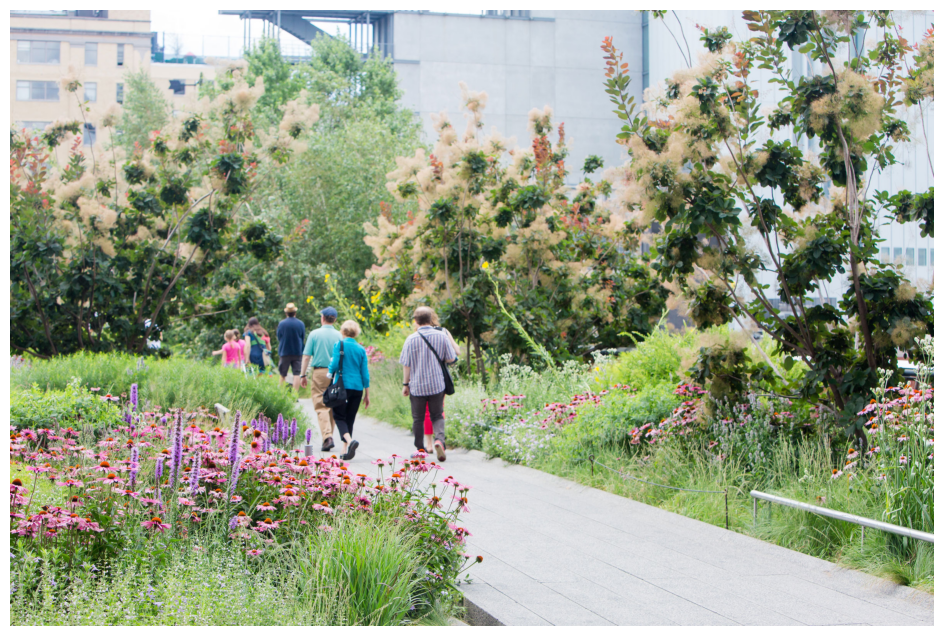


  1   Cotinus coggygria              92.531% -- **
  2   Reynoutria japonica             2.749% -- 
  3   Muhlenbergia capillaris         1.427% -- **
  4   Muhlenbergia sericea            0.791% -- *
  5   Cotinus obovatus                0.692% -- **
  6   Anemanthele lessoniana          0.598% -- 
  7   Cenchrus setaceus               0.070% -- 
  8   Castanopsis fissa               0.061% -- 
  9   Miscanthus sinensis             0.048% -- 
  10  Cuscuta epithymum               0.047% -- *
  11  Campuloclinium macrocephalum    0.040% -- 
  12  Silphium perfoliatum            0.037% -- *
  13  Phragmites australis            0.037% -- **
  14  Melica transsilvanica           0.031% -- 
  15  Cortaderia selloana             0.030% -- 
  16  Corymbia ficifolia              0.026% -- 
  17  Miscanthus sacchariflorus       0.024% -- 
  18  Cenchrus longisetus             0.021% -- 
  19  Callistephus chinensis          0.020% -- 
  20  Loropetalum chinense            0.018% -- 
  21  Ag

In [26]:
# Let's test on an image of known species from outside the train/test dataset


df = pd.read_csv('/home/photon/sense/3cology/research/herbarium/high_line_species_v2.csv', header=None, names=['species_cultivar'])

# Extract species names
high_line_species_dict = {}
for species_name in df['species_cultivar']:
    high_line_species_dict[species_name] = True
    genus_name = species_name.split()[0]
    high_line_species_dict[genus_name] = True
    
    
# for species in sorted(species_dict.keys()):
#     print(f"{species}")

image_paths = [   #"/home/photon/Downloads/high_line_1.jpg",
                  #"/home/photon/Downloads/high_line_2.jpg",
                  #"/home/photon/Downloads/high_line_3.jpg",
                  #"/home/photon/Downloads/high_line_4.jpg",
                  "/home/photon/Downloads/high_line_5.jpg",
                  #"/home/photon/Downloads/high_line_6.jpg"
              ]

# new york city
# latitude_longitudes = [ [40.730610, -73.935242],
#                         [40.730610, -73.935242],
#                         [40.730610, -73.935242],
#                         [40.730610, -73.935242],
#                         [40.730610, -73.935242],
#                         ]

# # hudson, ny
# latitude_longitudes = [ [42.2529, -73.7900],
#                         [42.2529, -73.7900],
#                         [42.2529, -73.7900],
#                         [42.2529, -73.7900],
#                         [42.2529, -73.7900]
#                         ]


# # queens, ny
# latitude_longitudes = [ [40.7282, -73.7949],
#                         [40.7282, -73.7949],
#                         [40.7282, -73.7949],
#                         [40.7282, -73.7949],
#                         [40.7282, -73.7949]
#                         ]

# downtown manhattan, ny
latitude_longitudes = [ [0.0000, 0.0000] for image_path in image_paths]

# # yonkers, ny
# latitude_longitudes = [ [40.9312, -73.8988],
#                         [40.9312, -73.8988],
#                         [40.9312, -73.8988],
#                         [40.9312, -73.8988],
#                         [40.9312, -73.8988]
#                         ]








# brazil
# latitude_longitudes = [ [-22.9068, -43.1729],
#                         [-22.9068, -43.1729],
#                         [-22.9068, -43.1729],
#                         [-22.9068, -43.1729],
#                         [-22.9068, -43.1729],
#                         ]



    
print("\nInput Image:\n")

print("\nA.I. Attention Heatmap:\n")

print("\nSpecies Detection Probability:\n")

# target_layers = [model.transformer.blocks[-1].norm1]

# Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

for image_path, lat_lon in zip(image_paths, latitude_longitudes):
    test_image = Image.open(image_path)
    lat = lat_lon[0]
    lon = lat_lon[1]
    
    desired_height_in_inches = 8  # Set your desired height in inches
    aspect_ratio = test_image.width / test_image.height
    desired_width_in_inches = desired_height_in_inches * aspect_ratio
    plt.figure(figsize=(desired_width_in_inches, desired_height_in_inches))
    
    plt.imshow(test_image)
    plt.axis('off')
    plt.show()

    if test_image.mode == 'RGBA':
        # Convert to RGB
        test_image = test_image.convert('RGB')

    preprocessed_image = image_preprocessing["test"](test_image)

    latitude  = torch.tensor(lat, dtype=torch.float32).to(device)
    longitude = torch.tensor(lon, dtype=torch.float32).to(device)
    
    transformed_image = image_preprocessing["test"](original_image)
    
    with torch.no_grad():
        geo_xyz = get_geo_xyz(latitude.unsqueeze(0), longitude.unsqueeze(0))

        # model prediction
        prediction = model(preprocessed_image.unsqueeze(0).to(device),  geo_xyz.to(device)) # ,

#     input_tensor = preprocessed_image.unsqueeze(0).to(device)

#     targets = [ClassifierOutputTarget(15257)]

    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
#     grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
#     grayscale_cam = grayscale_cam[0, :]
#     visualization = show_cam_on_image(test_image, grayscale_cam, use_rgb=True)

#         display_attention(original_image=test_image, preprocessed_image=preprocessed_image)

    sorted_predictions, sorted_class_indices = torch.sort(prediction.squeeze(), descending=True)
    probability_distribution = torch.softmax(sorted_predictions, dim=0)

    prediction_report = ""
    top_n_predictions = 30
    for i in range(top_n_predictions):
        if i % 1 == 0:
            prediction_report += "\n  "
        probability = probability_distribution[i] * 100
        class_index = sorted_class_indices[i]
        species_name = species_id_to_name[int(class_names[class_index])]
        
        correct = ""
        if species_name in high_line_species_dict:
            correct = "**"
        else:
            # check for genus name
            genus_name = species_name.split()[0]
            if genus_name in high_line_species_dict:
                correct = "*"

        # Adjust the width as needed for alignment
        prediction_report += "{:<3} {:<30} {:>6.3f}% -- {}".format(i+1, species_name, probability, correct)

    prediction_report = prediction_report.rstrip(",")
    print(prediction_report)
    


In [22]:
# save the model
torch.save(model.state_dict(), '{}/large_geo_classifier_33k_422k_epochs.pth'.format(main_directory))

In [ ]:
def calculate_accuracy(outputs, labels):
    # Convert outputs to predicted classes
    _, predicted_classes = torch.max(outputs, 1)
    # Calculate accuracy
    correct_predictions = (predicted_classes == labels).sum().item()
    total_predictions = labels.size(0)
    return correct_predictions / total_predictions

print("Training...")
epoch = 76540
max_epochs = 500000

# train_losses = []
# train_accuracies = []

test_losses = []
test_accuracies = []

validation_testing_frequency = 10
save_model_frequency = 5000


def train_epoch(data):
    # get the input batch and the labels
    batch_of_images, latitudes, longitudes, labels = data #  geo_xyz

    geo_xyz = get_geo_xyz(latitudes, longitudes)

    # zero the parameter gradients
    optimizer.zero_grad()

    # model prediction
    output = model(batch_of_images.to(device), geo_xyz).squeeze(dim=1) #  geo_xyz.to(device)

    # compute loss and do backpropagation
    loss = criterion(output, labels.to(device))
    
#     print(loss.item())
    
    loss.backward()
    optimizer.step()
    scheduler.step()

    with torch.no_grad():
        train_losses.append(loss.item())

        # Calculate and record batch accuracy
        accuracy = calculate_accuracy(output, labels.to(device))
        train_accuracies.append(accuracy)
        
    
def test_epoch():
    # zero the parameter gradients
    optimizer.zero_grad()
    
    with torch.no_grad():
        mean_train_loss = torch.mean(torch.tensor(train_losses[-30:]))
        mean_train_accuracy = torch.mean(torch.tensor(train_accuracies[-30:]))

        test_data_iter = iter(dataloaders["test"])
        test_batch_of_images, test_latitudes, test_longitudes, test_labels = next(test_data_iter) # test_geo_xyz

        test_geo_xyz = get_geo_xyz(test_latitudes, test_longitudes)

        # model prediction
        test_output = model(test_batch_of_images.to(device), test_geo_xyz).squeeze(dim=1) # , test_geo_xyz.to(device)
        test_loss = criterion(test_output, test_labels.to(device))

        test_losses.append(test_loss.item())
        test_accuracy = calculate_accuracy(test_output, test_labels.to(device))
        test_accuracies.append(test_accuracy)

        mean_test_loss = torch.mean(torch.tensor(test_losses[-6:]))
        mean_test_accuracy = torch.mean(torch.tensor(test_accuracies[-6:]))

        current_lr = scheduler.get_last_lr()[0]

        print("  -> ({:,}): TRAIN: [Loss = {:.5f}, Accuracy = {:.5f}%], TEST: [Loss = {:.5f}, Accuracy = {:.5f}%], LR: {:.8f}".format(epoch, mean_train_loss, 100*mean_train_accuracy, mean_test_loss, 100*mean_test_accuracy, current_lr), flush=True)


while epoch < max_epochs:
    try:
        for data in dataloaders["train"]:

            if epoch >= max_epochs:
                break
                    
            train_epoch(data=data)
            
            if epoch % validation_testing_frequency == 0:
                test_epoch()
                
            epoch += 1

            if epoch % save_model_frequency == 0 and epoch != 0:
                torch.save(model.state_dict(), '{}/large_geo_species_classifier_33k_epoch{}.pth'.format(main_directory,epoch))
            
    except Exception as e:
        print("Error: {}".format(e))
        traceback.print_exc()
        continue

In [ ]:
# save the model
torch.save(model.state_dict(), '{}/large_geo_classifier_33k_v1.pth'.format(main_directory))